## **Statistical Arbitrage Backtesting**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
from functools import partial
import os

import warnings
warnings.filterwarnings('ignore') 

from IPython.display import display
pd.set_option('expand_frame_repr', True) 
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180) #
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


In [3]:
from utils.ArbUtils import *

#### **Exploratory Data Analysis**

In [4]:
market_data = pd.read_csv("price_stock.csv", index_col=[0])
market_data.index.name = 'time'
market_data.columns = [market_data.columns.str[-2:], market_data.columns.str[:-3]]
market_data

AA                                    BB                                    CC            ...       MM                 NN                               \
                 BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume  ... AskPrice AskVolume BidPrice BidVolume AskPrice AskVolume   
time                                                                                                             ...                                                            
01/01/2018 00:05    80.00       135    80.25       135   100.55       105   100.85       105    97.85       112  ...    95.20       140   137.20       122   137.60       122   
01/01/2018 00:10    79.95       124    80.20       145   100.50       104   100.80       113    97.80       109  ...    95.20       144   137.20       111   137.55       110   
01/01/2018 00:15    79.95       124    80.15       155   100.65       100   100.95       107    97.85       110  ...    95.25       156   137.25       117   137.65       106   
01/01/2018 00:20    79.95       130    80.10       154   100.75       112   101.05       109    97.95       100  ...    95.25       153   137.25       107   137.65        97   
01/01/2018 00:25    79.90       121    80.10       138   100.60       126   100.85       124    97.95        98  ...    95.20       153   137.15       111   137.60       109   
...                   ...       ...      ...       ...      ...       ...      ...       ...      ...       ...  ...      ...       ...      ...       ...      ...       ...   
28/02/2018 23:35    92.85       180    93.15       201    95.75       139    96.00       123    96.35       125  ...    90.55       169   132.20       174   132.60       145   
28/02/2018 23:40    92.85       163    93.15       180    95.75       155    96.00       122    96.50       119  ...    90.60       161   132.25       188   132.60       142   
28/02/2018 23:45    92.80       169    93.05       192    95.75       128    96.00       113    96.50       120  ...    90.55       144   132.25       174   132.60       147   
28/02/2018 23:50    92.70       143    93.00       173    95.80       119    96.05       100    96.40       127  ...    90.55       148   132.10       153   132.45       149   
28/02/2018 23:55    92.80       147    93.10       156    95.75       113    96.00       105    96.60       106  ...    90.55       143   132.15       153   132.50       126   

                       OO                               
                 BidPrice BidVolume AskPrice AskVolume  
time                                                    
01/01/2018 00:05    88.80       109    89.05       109  
01/01/2018 00:10    88.75       115    89.00       100  
01/01/2018 00:15    88.70        92    89.00       100  
01/01/2018 00:20    88.75       100    89.00       113  
01/01/2018 00:25    88.75        98    89.00       112  
...                   ...       ...      ...       ...  
28/02/2018 23:35    93.80       123    94.05        94  
28/02/2018 23:40    93.85       135    94.10       103  
28/02/2018 23:45    93.80       126    94.05       102  
28/02/2018 23:50    93.80       115    94.10       110  
28/02/2018 23:55    93.85       110    94.15       114  

[16991 rows x 60 columns]

In [5]:
stock_names = list(market_data.columns.get_level_values(level=0).unique())
print(stock_names)

['AA', 'BB', 'CC', 'DD', 'EE', 'FF', 'GG', 'HH', 'II', 'JJ', 'KK', 'LL', 'MM', 'NN', 'OO']


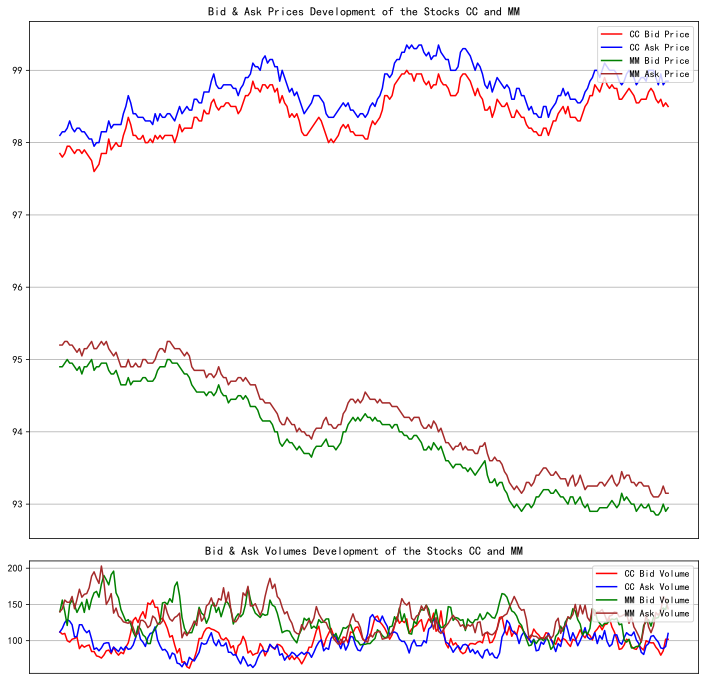

In [6]:
# Specify variable used for Plotting
market_data_segmented = market_data[:250]

# Defining Plots
def bid_ask_price_plot(stock1, stock2):

    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=4, colspan=1)
    plt.title('Bid & Ask Prices Development of the Stocks ' + stock1 + " and " + stock2)
    plt.grid()

    ax1.plot(market_data_segmented.index, market_data_segmented[stock1, 'BidPrice'], color='r')
    ax1.plot(market_data_segmented.index, market_data_segmented[stock1, 'AskPrice'], color='b')
    ax1.plot(market_data_segmented.index, market_data_segmented[stock2, 'BidPrice'], color='g')
    ax1.plot(market_data_segmented.index, market_data_segmented[stock2, 'AskPrice'], color='brown')

    # remove timestamps
    ax1.axes.get_xaxis().set_visible(False)

    ax1.legend([stock1 + " Bid Price", stock1 + " Ask Price", stock2 + " Bid Price", stock2 + " Ask Price"], loc='upper right')

def bid_ask_volume_plot(stock1, stock2):
    '''
    This function is very similar to above's function with the exception
    of creating a smaller subplot and using different data. This function
    is meant for displaying volumes. 
    '''
    ax2 = plt.subplot2grid((5, 1), (4, 0), rowspan=1, colspan=1)
    plt.title('Bid & Ask Volumes Development of the Stocks ' + stock1 + " and " + stock2)
    plt.grid()
    ax2.plot(market_data_segmented.index, market_data_segmented[stock1, 'BidVolume'], color='r')
    ax2.plot(market_data_segmented.index, market_data_segmented[stock1, 'AskVolume'], color='b')
    ax2.plot(market_data_segmented.index, market_data_segmented[stock2, 'BidVolume'], color='g')
    ax2.plot(market_data_segmented.index, market_data_segmented[stock2, 'AskVolume'], color='brown')

    # remove timestamps
    ax2.axes.get_xaxis().set_visible(False)
    ax2.legend([stock1 + " Bid Volume", stock1 + " Ask Volume", stock2 + " Bid Volume", stock2 + " Ask Volume"], loc='upper right')

plt.figure(figsize=(12, 12))
plt.show(bid_ask_price_plot("CC", "MM"), bid_ask_volume_plot("CC", "MM"))

In [7]:
# Calculate mid-prices of each stock and add them to the DataFrame
for stock in stock_names:
    market_data[stock,'MidPrice'] = (market_data[stock,'BidPrice'] + market_data[stock,'AskPrice']) / 2
    market_data[stock,'MidVolume'] = (market_data[stock,'BidVolume'] + market_data[stock,'AskVolume']) / 2
    market_data = market_data.sort_index(axis=1)
    
market_data.head()

AA                                                       BB                               ...       NN                                    OO            \
                 AskPrice AskVolume BidPrice BidVolume MidPrice MidVolume AskPrice AskVolume BidPrice BidVolume  ... BidPrice BidVolume MidPrice MidVolume AskPrice AskVolume   
time                                                                                                             ...                                                            
01/01/2018 00:05    80.25       135    80.00       135   80.125     135.0   100.85       105   100.55       105  ...   137.20       122  137.400     122.0    89.05       109   
01/01/2018 00:10    80.20       145    79.95       124   80.075     134.5   100.80       113   100.50       104  ...   137.20       111  137.375     110.5    89.00       100   
01/01/2018 00:15    80.15       155    79.95       124   80.050     139.5   100.95       107   100.65       100  ...   137.25       117  137.450     111.5    89.00       100   
01/01/2018 00:20    80.10       154    79.95       130   80.025     142.0   101.05       109   100.75       112  ...   137.25       107  137.450     102.0    89.00       113   
01/01/2018 00:25    80.10       138    79.90       121   80.000     129.5   100.85       124   100.60       126  ...   137.15       111  137.375     110.0    89.00       112   

                                                        
                 BidPrice BidVolume MidPrice MidVolume  
time                                                    
01/01/2018 00:05    88.80       109   88.925     109.0  
01/01/2018 00:10    88.75       115   88.875     107.5  
01/01/2018 00:15    88.70        92   88.850      96.0  
01/01/2018 00:20    88.75       100   88.875     106.5  
01/01/2018 00:25    88.75        98   88.875     105.0  

[5 rows x 90 columns]

<AxesSubplot:xlabel='time'>

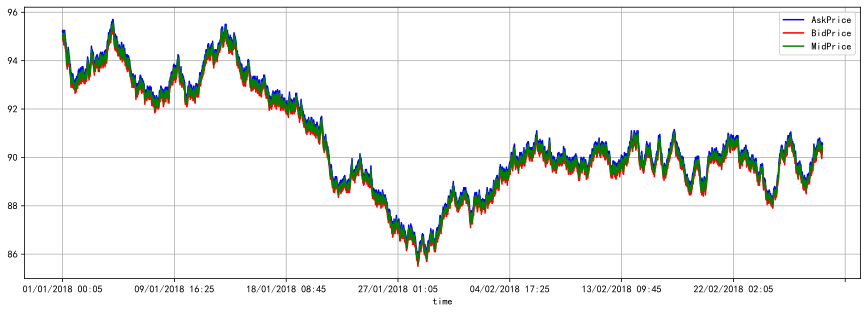

In [8]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
market_data['MM'][['AskPrice', 'BidPrice', 'MidPrice']].plot(kind='line',color=['b','r','g'],ax=ax, label=["Ask Price", "Mid Price", "Bid Price"], legend=True, grid=True)

#### **Cointegration Tests**

In [9]:
%%time
# Obtain the statistical parameters for each and every pair
data_analysis = {'Pairs': [],
                 'Constant': [],
                 'Gamma': [],
                 'Alpha': [],
                 'P-Value': []}

data_zvalues = {}

for stock1 in stock_names:
    for stock2 in stock_names:
        if stock1 != stock2:
            if (stock2, stock1) in data_analysis['Pairs']:
                continue

            pairs = stock1, stock2
            constant, gamma, alpha, zvalue = fit_ols(np.log(market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))
            adfstat, pvalue = granger_cointegration_test(np.log(market_data[stock1, 'MidPrice']), np.log(market_data[stock2, 'MidPrice']))

            data_analysis['Pairs'].append(pairs)
            data_analysis['Constant'].append(constant)
            data_analysis['Gamma'].append(gamma)
            data_analysis['Alpha'].append(alpha)
            data_analysis['P-Value'].append(pvalue)

            data_zvalues[pairs] = zvalue
            
data_analysis = round(pd.DataFrame(data_analysis),4).set_index('Pairs')

Wall time: 2.01 s


In [10]:
data_analysis

Constant   Gamma   Alpha  P-Value
Pairs                                      
(AA, BB)    4.2082  0.0571 -0.0001   0.5739
(AA, CC)    6.4143 -0.4308 -0.0001   0.9207
(AA, DD)    4.2125  0.0540 -0.0001   0.6103
(AA, EE)   15.0252 -2.1503 -0.0003   0.2186
(AA, FF)   10.6286 -1.3206 -0.0002   0.4687
...            ...     ...     ...      ...
(LL, NN)    4.7110 -0.0034 -0.0005   0.2644
(LL, OO)    3.8857  0.1790 -0.0005   0.2344
(MM, NN)   -2.9034  1.5153 -0.0002   0.0000
(MM, OO)    7.3161 -0.6221 -0.0005   0.2670
(NN, OO)    6.6277 -0.3847 -0.0005   0.2389

[105 rows x 4 columns]

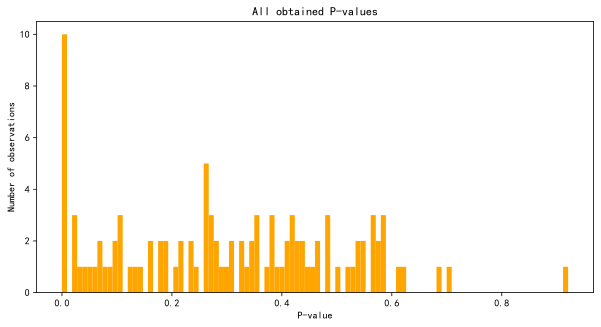

In [11]:
# Visualize the P-values
def plot_pvalues():
    """
    This function plots all obtained P-values.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(data_analysis['P-Value'], bins=100, color='orange')
    plt.xlabel('P-value')
    plt.ylabel('Number of observations')
    plt.title('All obtained P-values')
    plt.show()

plot_pvalues()

In [12]:
# Show Top 10 and Bottom 10
display(data_analysis.sort_values('P-Value')[:10])
display(data_analysis.sort_values('P-Value')[-10:])

Constant   Gamma   Alpha  P-Value
Pairs                                      
(FF, NN)   -2.6104  1.4881 -0.0022   0.0000
(FF, MM)    0.3061  0.9676 -0.0338   0.0000
(BB, DD)   -2.4182  1.4758 -0.0075   0.0000
(DD, HH)   -1.6797  1.2787 -0.0040   0.0000
(BB, JJ)   -2.4809  1.6206 -0.0000   0.0000
(DD, JJ)    0.2277  1.0356  0.0002   0.0000
(MM, NN)   -2.9034  1.5153 -0.0002   0.0000
(BB, HH)   -4.8181  1.8712 -0.0024   0.0009
(HH, JJ)    1.9492  0.7041 -0.0002   0.0010
(AA, II)    0.0445  0.9944 -0.0002   0.0031

Constant   Gamma   Alpha  P-Value
Pairs                                      
(AA, BB)    4.2082  0.0571 -0.0001   0.5739
(EE, JJ)    5.0700 -0.0369 -0.0002   0.5765
(AA, MM)   10.2964 -1.2938 -0.0001   0.5812
(AA, KK)    9.7238 -1.1233 -0.0001   0.5826
(AA, JJ)    4.1324  0.0773 -0.0001   0.5860
(AA, DD)    4.2125  0.0540 -0.0001   0.6103
(CC, EE)    1.7955  0.5551 -0.0002   0.6199
(CC, OO)    8.4182 -0.8627 -0.0002   0.6888
(CC, GG)    2.8739  0.3184 -0.0002   0.7055
(AA, CC)    6.4143 -0.4308 -0.0001   0.9207

In [13]:
# Selecting tradable pairs where P-Value < 0.01 and create a seperate DataFrame containing these pairs
tradable_pairs_analysis = data_analysis[data_analysis['P-Value'] < 0.01].sort_values('P-Value')

tradable_pairs_analysis

Constant   Gamma   Alpha  P-Value
Pairs                                      
(BB, DD)   -2.4182  1.4758 -0.0075   0.0000
(BB, JJ)   -2.4809  1.6206 -0.0000   0.0000
(DD, HH)   -1.6797  1.2787 -0.0040   0.0000
(DD, JJ)    0.2277  1.0356  0.0002   0.0000
(FF, MM)    0.3061  0.9676 -0.0338   0.0000
(FF, NN)   -2.6104  1.4881 -0.0022   0.0000
(MM, NN)   -2.9034  1.5153 -0.0002   0.0000
(BB, HH)   -4.8181  1.8712 -0.0024   0.0009
(HH, JJ)    1.9492  0.7041 -0.0002   0.0010
(AA, II)    0.0445  0.9944 -0.0002   0.0031

In [14]:
# Get all the tradable stock pairs into a list
stock_pairs = list(tradable_pairs_analysis.index.values.tolist())

# Show the Pairs
stock_pairs

[('BB', 'DD'),
 ('BB', 'JJ'),
 ('DD', 'HH'),
 ('DD', 'JJ'),
 ('FF', 'MM'),
 ('FF', 'NN'),
 ('MM', 'NN'),
 ('BB', 'HH'),
 ('HH', 'JJ'),
 ('AA', 'II')]

We now build further on the Data Analysis section by zooming in onto the pairs and calculate additional data on the error correction terms.

In [15]:
# Create a list of unique tradable stocks
list_stock1 = [stock[0] for stock in stock_pairs]
list_stock2 = [stock[1] for stock in stock_pairs]

for stock in list_stock2:
    list_stock1.append(stock)
    
unique_stock_list = list(set(list_stock1))

# Create a new DataFrame containing all market information for the tradable pairs
tradable_pairs_data = market_data[unique_stock_list]
tradable_pairs_data.head()

II                                                       HH                               ...       JJ                                    DD            \
                 AskPrice AskVolume BidPrice BidVolume MidPrice MidVolume AskPrice AskVolume BidPrice BidVolume  ... BidPrice BidVolume MidPrice MidVolume AskPrice AskVolume   
time                                                                                                             ...                                                            
01/01/2018 00:05    83.80       124    83.55       124   83.675     124.0   154.40       136    154.0       136  ...    79.80       156   79.925     156.0   117.30       102   
01/01/2018 00:10    83.65       134    83.40       156   83.525     145.0   154.35       132    153.9       131  ...    79.75       157   79.875     159.0   117.25       103   
01/01/2018 00:15    83.65       129    83.40       132   83.525     130.5   154.35       139    153.9       139  ...    79.65       152   79.775     148.5   117.20       113   
01/01/2018 00:20    83.80       129    83.55       140   83.675     134.5   154.30       173    153.9       141  ...    79.65       154   79.800     147.0   117.30       117   
01/01/2018 00:25    83.85       116    83.55       136   83.700     126.0   154.25       166    153.9       140  ...    79.65       158   79.800     147.5   117.30       129   

                                                        
                 BidPrice BidVolume MidPrice MidVolume  
time                                                    
01/01/2018 00:05   116.95       102  117.125     102.0  
01/01/2018 00:10   116.95        98  117.100     100.5  
01/01/2018 00:15   116.90       109  117.050     111.0  
01/01/2018 00:20   116.95       100  117.125     108.5  
01/01/2018 00:25   116.95       106  117.125     117.5  

[5 rows x 54 columns]

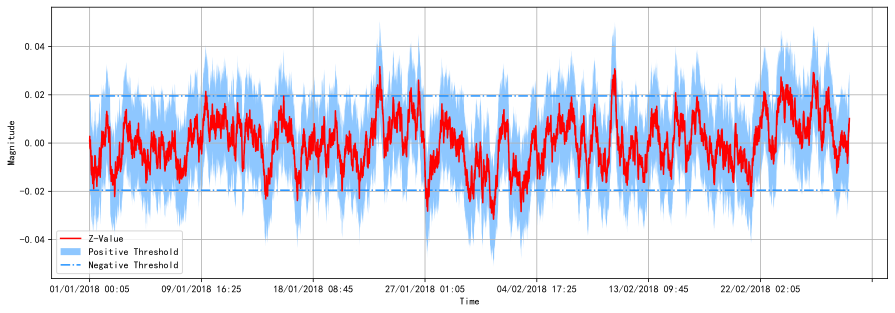

In [16]:
for pair in stock_pairs[:1]: 
    zvalue = data_zvalues[pair]
    plt.figure(figsize=(15,5))
    # plt.title('Error-correction term stock pair {}'.format(pair))
    zvalue.plot(color='r')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    lower = np.array(zvalue) - 1.96*zvalue.std()
    upper = np.array(zvalue) + 1.96*zvalue.std()
    plt.fill_between(x=zvalue.index, y1=lower, y2=upper, facecolor="dodgerblue", alpha=0.5)
    xmin = 0
    xmax = len(zvalue)
    plt.hlines(zvalue.mean()+1.96*zvalue.std(), xmin, xmax, colors='dodgerblue', linestyles='dashdot') 
    plt.hlines(zvalue.mean()-1.96*zvalue.std(), xmin, xmax, 'dodgerblue', linestyles='dashdot') 
    plt.legend(['Z-Value', 'Positive Threshold', 'Negative Threshold'], loc='lower left')
    plt.grid(True)
    # plt.savefig("./imgs/res_%s_%s"%(pair[0], pair[1]), dpi=400)
    plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.


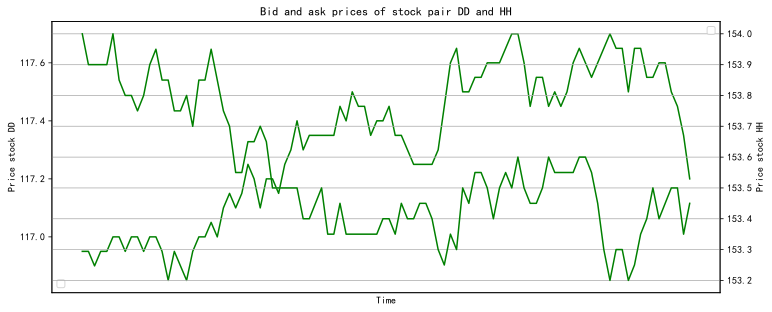

In [17]:
# Select randomly chosen pair from the tradable stock and visualize bid and ask prices, bid and ask volumes, and the z-values
import random

# Choose random stock
random_pair = random.choice(stock_pairs)

# Create a plot showing the bid and ask prices of a randomly chosen stock
def Plot_RandomPair_BidAskPrices():
    """
    This function plots the bid and ask price of a randomly chosen tradable pair.
    """
    plt.figure(figsize=(12,5))
    plt.title('Bid and ask prices of stock pair {} and {}'.format(random_pair[0], random_pair[1]))
    
    # plt.plot(tradable_pairs_data[random_pair[0], 'AskPrice'].iloc[:100], 'r')
    plt.plot(tradable_pairs_data[random_pair[0], 'BidPrice'].iloc[:100], 'g')
    plt.xlabel('Time')
    plt.ylabel('Price stock {}'.format(random_pair[0]))
    plt.legend(loc='lower left')
    
    plt.twinx()
    # plt.plot(tradable_pairs_data[random_pair[1], 'AskPrice'].iloc[:100], 'r')
    plt.plot(tradable_pairs_data[random_pair[1], 'BidPrice'].iloc[:100], 'g')
    plt.xticks([])
    plt.ylabel('Price stock {}'.format(random_pair[1]))
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.show()

Plot_RandomPair_BidAskPrices()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


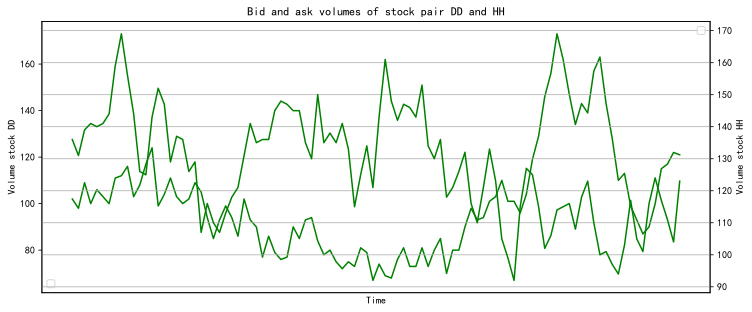

In [18]:
# Create a plot showing the bid and ask volumes of a randomly chosen stock
def Plot_RandomPair_BidAskVolumes(): # Plot not really clarifying, maybe other kind of plot?
    """
    This function plots the bid and ask volumes of a randomly chosen tradable pair.
    """
    plt.figure(figsize=(12,5))
    plt.title('Bid and ask volumes of stock pair {} and {}'.format(random_pair[0],random_pair[1]))
    
    # plt.plot(tradable_pairs_data[random_pair[0], 'AskVolume'].iloc[:100], 'r')
    plt.plot(tradable_pairs_data[random_pair[0], 'BidVolume'].iloc[:100], 'g')
    plt.xlabel('Time')
    plt.ylabel('Volume stock {}'.format(random_pair[0]))
    plt.legend(loc='lower left')
    
    plt.twinx()
    # plt.plot(tradable_pairs_data[random_pair[1], 'AskVolume'].iloc[:100], 'r')
    plt.plot(tradable_pairs_data[random_pair[1], 'BidVolume'].iloc[:100], 'g')
    plt.xticks([])
    plt.ylabel('Volume stock {}'.format(random_pair[1]))
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.show()

Plot_RandomPair_BidAskVolumes()

In [19]:
from models.Vasicek import *

In [20]:
# Create a Dataframe containing information about the error-correction term of each pair
data_error_correction_term = {'Pair': [],
                              'CountZeroCrossings': [],
                              'TradingPeriod': [],
                              'LongRunMean': [],
                              'Std': [],
                              'OU_kappa':[],
                              'OU_theta':[],
                              'OU_sigma':[]
                              }

for pair in stock_pairs:
    zvalue = data_zvalues[pair]
    my_array = np.array(zvalue)
    count = ((my_array[:-1] * my_array[1:]) < 0).sum()
    trading_period = 1 / count
    long_run_mean = zvalue.mean()
    std = zvalue.std()

    # estimate OU parameters
    OU_params = estimate_OU_params(my_array)

    data_error_correction_term['Pair'].append(pair)
    data_error_correction_term['CountZeroCrossings'].append(count)
    data_error_correction_term['TradingPeriod'].append(trading_period)
    data_error_correction_term['LongRunMean'].append(round(long_run_mean, 4))
    data_error_correction_term['Std'].append(round(std, 4))
    data_error_correction_term['OU_kappa'].append(round(OU_params.alpha, 5))
    data_error_correction_term['OU_theta'].append(round(OU_params.gamma, 5))
    data_error_correction_term['OU_sigma'].append(round(OU_params.beta, 5))
data_error_correction_term = pd.DataFrame(data_error_correction_term).set_index('Pair')

data_error_correction_term

CountZeroCrossings  TradingPeriod  LongRunMean     Std  OU_kappa  OU_theta  OU_sigma
Pair                                                                                          
(BB, DD)                 660       0.001515         -0.0  0.0100   0.00685   0.00008   0.00117
(BB, JJ)                1475       0.000678          0.0  0.0044   0.03656   0.00001   0.00117
(DD, HH)                 396       0.002525          0.0  0.0097   0.00342  -0.00000   0.00080
(DD, JJ)                 592       0.001689         -0.0  0.0072   0.00598  -0.00002   0.00078
(FF, MM)                1413       0.000708         -0.0  0.0031   0.03689  -0.00001   0.00083
(FF, NN)                 705       0.001418          0.0  0.0061   0.00900   0.00001   0.00082
(MM, NN)                 627       0.001595         -0.0  0.0068   0.00701   0.00006   0.00081
(BB, HH)                 334       0.002994         -0.0  0.0181   0.00209   0.00025   0.00117
(HH, JJ)                 363       0.002755          0.0  0.0090   0.00212  -0.00016   0.00058
(AA, II)                 363       0.002755          0.0  0.0214   0.00154   0.00279   0.00108

In [21]:
res_summary = pd.merge(tradable_pairs_analysis, data_error_correction_term, left_index=True, right_index=True)
# res_summary[['Constant', 'Gamma', 'Std', 'OU_kappa', 'OU_theta', 'OU_sigma']].to_latex("./res/tab1.tex")
res_summary

Constant   Gamma   Alpha  P-Value  CountZeroCrossings  TradingPeriod  LongRunMean     Std  OU_kappa  OU_theta  OU_sigma
(BB, DD)   -2.4182  1.4758 -0.0075   0.0000                 660       0.001515         -0.0  0.0100   0.00685   0.00008   0.00117
(BB, JJ)   -2.4809  1.6206 -0.0000   0.0000                1475       0.000678          0.0  0.0044   0.03656   0.00001   0.00117
(DD, HH)   -1.6797  1.2787 -0.0040   0.0000                 396       0.002525          0.0  0.0097   0.00342  -0.00000   0.00080
(DD, JJ)    0.2277  1.0356  0.0002   0.0000                 592       0.001689         -0.0  0.0072   0.00598  -0.00002   0.00078
(FF, MM)    0.3061  0.9676 -0.0338   0.0000                1413       0.000708         -0.0  0.0031   0.03689  -0.00001   0.00083
(FF, NN)   -2.6104  1.4881 -0.0022   0.0000                 705       0.001418          0.0  0.0061   0.00900   0.00001   0.00082
(MM, NN)   -2.9034  1.5153 -0.0002   0.0000                 627       0.001595         -0.0  0.0068   0.00701   0.00006   0.00081
(BB, HH)   -4.8181  1.8712 -0.0024   0.0009                 334       0.002994         -0.0  0.0181   0.00209   0.00025   0.00117
(HH, JJ)    1.9492  0.7041 -0.0002   0.0010                 363       0.002755          0.0  0.0090   0.00212  -0.00016   0.00058
(AA, II)    0.0445  0.9944 -0.0002   0.0031                 363       0.002755          0.0  0.0214   0.00154   0.00279   0.00108

#### **Threshold Analysis**

In the next section, the pairs with the highest profits those that are unique (prevent having a stock as 'BB' be traded twice) will be picked to determine the final profit.

In [22]:
# Create a new column within the earlier defined DataFrame with Z-Values of all stock pairs
for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    tradable_pairs_data[stock1+stock2, 'Z-Value'] = data_zvalues[stock1,stock2]

In [23]:
tradable_pairs_data

II                                                       HH                               ...      BBDD      BBJJ      DDHH      DDJJ      FFMM      FFNN  \
                 AskPrice AskVolume BidPrice BidVolume MidPrice MidVolume AskPrice AskVolume BidPrice BidVolume  ...   Z-Value   Z-Value   Z-Value   Z-Value   Z-Value   Z-Value   
time                                                                                                             ...                                                               
01/01/2018 00:05    83.80       124    83.55       124   83.675     124.0   154.40       136   154.00       136  ...  0.000798 -0.006871  0.000814 -0.001543  0.001858 -0.000489   
01/01/2018 00:10    83.65       134    83.40       156   83.525     145.0   154.35       132   153.90       131  ...  0.000617 -0.006354  0.001222 -0.001109  0.002306  0.000230   
01/01/2018 00:15    83.65       129    83.40       132   83.525     130.5   154.35       139   153.90       139  ...  0.002736 -0.002834  0.000795 -0.000238  0.002468  0.000089   
01/01/2018 00:20    83.80       129    83.55       140   83.675     134.5   154.30       173   153.90       141  ...  0.002782 -0.002350  0.001643  0.000078  0.002661  0.000537   
01/01/2018 00:25    83.85       116    83.55       136   83.700     126.0   154.25       166   153.90       140  ...  0.001046 -0.004086  0.001851  0.000078  0.003170  0.001349   
...                   ...       ...      ...       ...      ...       ...      ...       ...      ...       ...  ...       ...       ...       ...       ...       ...       ...   
28/02/2018 23:35    90.30       109    90.05       123   90.175     116.0   149.65        94   149.25       105  ...  0.008534 -0.000280  0.002309 -0.004466 -0.003719  0.000830   
28/02/2018 23:40    90.30        98    90.05        97   90.175      97.5   149.75       103   149.40       111  ...  0.008534  0.000770  0.001240 -0.003795 -0.004017  0.000786   
28/02/2018 23:45    90.40        97    90.10        96   90.250      96.5   149.65       114   149.30       121  ...  0.009189  0.002871  0.001651 -0.002896 -0.003687  0.000313   
28/02/2018 23:50    90.35        98    90.10        93   90.225      95.5   149.65       117   149.30       117  ...  0.009710  0.002867  0.001651 -0.003232 -0.003955  0.001999   
28/02/2018 23:55    90.45        90    90.15        98   90.300      94.0   149.70       116   149.30       115  ...  0.010172  0.002346  0.000771 -0.003898 -0.004397  0.000727   

                      MMNN      BBHH      HHJJ      AAII  
                   Z-Value   Z-Value   Z-Value   Z-Value  
time                                                      
01/01/2018 00:05 -0.001675  0.002720  0.004344 -0.063167  
01/01/2018 00:10 -0.001399  0.003133  0.004298 -0.062007  
01/01/2018 00:15 -0.001701  0.004623  0.005180 -0.062319  
01/01/2018 00:20 -0.001438  0.005918  0.004797 -0.064416  
01/01/2018 00:25 -0.001136  0.004485  0.004635 -0.065025  
...                    ...       ...       ...       ...  
28/02/2018 23:35  0.004611  0.012166 -0.002748  0.011450  
28/02/2018 23:40  0.004878  0.010602 -0.001456  0.011450  
28/02/2018 23:45  0.004049  0.011853 -0.001212  0.009817  
28/02/2018 23:50  0.006042  0.012374 -0.001440  0.009285  
28/02/2018 23:55  0.005193  0.011540 -0.001273  0.009535  

[16991 rows x 64 columns]

In [24]:
# Create a Dictionary that saves all Gamma values of each pair
gamma_dictionary = {}

for pair, value in tradable_pairs_analysis.iterrows():
    gamma_dictionary[pair]= value['Gamma']
    
gamma_dictionary

{('BB', 'DD'): 1.4758,
 ('BB', 'JJ'): 1.6206,
 ('DD', 'HH'): 1.2787,
 ('DD', 'JJ'): 1.0356,
 ('FF', 'MM'): 0.9676,
 ('FF', 'NN'): 1.4881,
 ('MM', 'NN'): 1.5153,
 ('BB', 'HH'): 1.8712,
 ('HH', 'JJ'): 0.7041,
 ('AA', 'II'): 0.9944}

In [25]:
# Create a Dictionary that saves all Standard Deviation values of each pair
std_dictionary = {}

for pair, value in data_error_correction_term.iterrows():
    std_dictionary[pair]= value['Std']
    
std_dictionary

{('BB', 'DD'): 0.01,
 ('BB', 'JJ'): 0.0044,
 ('DD', 'HH'): 0.0097,
 ('DD', 'JJ'): 0.0072,
 ('FF', 'MM'): 0.0031,
 ('FF', 'NN'): 0.0061,
 ('MM', 'NN'): 0.0068,
 ('BB', 'HH'): 0.0181,
 ('HH', 'JJ'): 0.009,
 ('AA', 'II'): 0.0214}

In [26]:
stock_pairs

[('BB', 'DD'),
 ('BB', 'JJ'),
 ('DD', 'HH'),
 ('DD', 'JJ'),
 ('FF', 'MM'),
 ('FF', 'NN'),
 ('MM', 'NN'),
 ('BB', 'HH'),
 ('HH', 'JJ'),
 ('AA', 'II')]

In [27]:
%%time
from tqdm import tqdm
from joblib import Parallel, delayed

limit = 10000 # maximum cash

def test_thre(pair):
    positions = {}
    stock1 = pair[0]
    stock2 = pair[1]
    gamma = gamma_dictionary[stock1,stock2]

    # perform a simple grid search
    for i in tqdm(np.linspace(0.05, 1.0, 10)):
        threshold = i * std_dictionary[stock1, stock2]
        current_position = 0
        current_position_stock1 = 0 
        current_position_stock2 = 0 
        column_name_stock1 = stock1 + ' Pos - Thres: ' + str(threshold)
        column_name_stock2 = stock2 + ' Pos - Thres: ' + str(threshold)
        
        BidPrice_Stock1 = tradable_pairs_data[stock1,'BidPrice'][0]
        AskPrice_Stock1 = tradable_pairs_data[stock1,'AskPrice'][0]
        BidPrice_Stock2 = tradable_pairs_data[stock2,'BidPrice'][0]
        AskPrice_Stock2 = tradable_pairs_data[stock2,'AskPrice'][0]
        # print("bidprice1", BidPrice_Stock1)
        # print("askprice1", AskPrice_Stock1)
        # print("bidprice2", BidPrice_Stock2)
        # print("askprice2", AskPrice_Stock2)
        positions[column_name_stock1] = []
        positions[column_name_stock2] = []
        
        for time, data_at_time in tradable_pairs_data.iterrows():
            
            BidVolume_Stock1 = data_at_time[stock1, 'BidVolume']
            AskVolume_Stock1 = data_at_time[stock1, 'AskVolume']
            BidVolume_Stock2 = data_at_time[stock2, 'BidVolume']
            AskVolume_Stock2 = data_at_time[stock2, 'AskVolume']
            # print("bidvolume1", BidVolume_Stock1)
            # print("askvolume1", AskVolume_Stock1)
            # print("bidvolume2", BidVolume_Stock2)
            # print("askvolume2", AskVolume_Stock2)
            zvalue = data_at_time[stock1+stock2,'Z-Value']

            # close positions if any
            if ((zvalue <= 0) & (current_position == 1)) | ((current_position == -1) & (zvalue >= 0)):
                current_position_stock1 = 0
                current_position_stock2 = 0
                current_position = 0 

            # long stock 2, short stock 1
            if (zvalue >= threshold) & (current_position == 0):
                hedge_ratio = gamma * (BidPrice_Stock1 / AskPrice_Stock2)
                max_order_stock1 = np.floor(limit/BidPrice_Stock1)
                max_order_stock2 = np.floor(limit/AskPrice_Stock2)
                # print("hedge_ratio",hedge_ratio)
                # print("max_order_stock1",max_order_stock1)
                # print("max_order_stock2",max_order_stock2)
                # trade is the qty for stock 2, then trade * hedge_ratio is the qty for stock 1
                trade = np.floor(min(BidVolume_Stock1*hedge_ratio, AskVolume_Stock2, max_order_stock1*hedge_ratio, max_order_stock2))
                # print("trade",trade)
                # print("trade/hedge",trade/hedge_ratio)
                current_position_stock1 = -np.floor(trade/hedge_ratio)
                current_position_stock2 = trade
                current_position = 1

            elif (zvalue <= -threshold) & (current_position == 0):
                hedge_ratio = gamma * (AskPrice_Stock1 / BidPrice_Stock2)
                max_order_stock1 = np.floor(limit/AskPrice_Stock1)
                max_order_stock2 = np.floor(limit/BidPrice_Stock2)
                # print("hedge_ratio",hedge_ratio)
                # print("max_order_stock1",max_order_stock1)
                # print("max_order_stock2",max_order_stock2)
                # trade is the qty for stock 2, then trade * hedge_ratio is the qty for stock 1
                trade = np.floor(min(AskVolume_Stock1*hedge_ratio, BidVolume_Stock2, max_order_stock1*hedge_ratio, max_order_stock2))
                # print("trade",trade)
                # print("trade/hedge",trade/hedge_ratio)
                current_position_stock1 = np.floor(trade/hedge_ratio)
                current_position_stock2 = -trade
                current_position = -1

            positions[column_name_stock1].append(current_position_stock1)
            positions[column_name_stock2].append(current_position_stock2)
        # break
    return pd.DataFrame(positions)
        
pos = Parallel(n_jobs=-1)(delayed(test_thre)(pair) for pair in tqdm(stock_pairs))
# pos = test_thre(stock_pairs[0])


100%|██████████| 10/10 [00:00<00:00, 1660.85it/s]


Wall time: 35.9 s


In [28]:
positions = pd.concat(pos, axis=1)
positions

BB Pos - Thres: 0.0005  DD Pos - Thres: 0.0005  BB Pos - Thres: 0.0015555555555555557  DD Pos - Thres: 0.0015555555555555557  BB Pos - Thres: 0.0026111111111111114  \
0                       -67.0                    85.0                                    0.0                                    0.0                                    0.0   
1                       -67.0                    85.0                                    0.0                                    0.0                                    0.0   
2                       -67.0                    85.0                                  -67.0                                   85.0                                  -67.0   
3                       -67.0                    85.0                                  -67.0                                   85.0                                  -67.0   
4                       -67.0                    85.0                                  -67.0                                   85.0                                  -67.0   
...                       ...                     ...                                    ...                                    ...                                    ...   
16986                   -67.0                    85.0                                  -67.0                                   85.0                                  -67.0   
16987                   -67.0                    85.0                                  -67.0                                   85.0                                  -67.0   
16988                   -67.0                    85.0                                  -67.0                                   85.0                                  -67.0   
16989                   -67.0                    85.0                                  -67.0                                   85.0                                  -67.0   
16990                   -67.0                    85.0                                  -67.0                                   85.0                                  -67.0   

       DD Pos - Thres: 0.0026111111111111114  BB Pos - Thres: 0.0036666666666666666  DD Pos - Thres: 0.0036666666666666666  BB Pos - Thres: 0.004722222222222222  \
0                                        0.0                                    0.0                                    0.0                                   0.0   
1                                        0.0                                    0.0                                    0.0                                   0.0   
2                                       85.0                                    0.0                                    0.0                                   0.0   
3                                       85.0                                    0.0                                    0.0                                   0.0   
4                                       85.0                                    0.0                                    0.0                                   0.0   
...                                      ...                                    ...                                    ...                                   ...   
16986                                   85.0                                  -64.0                                   82.0                                 -62.0   
16987                                   85.0                                  -64.0                                   82.0                                 -62.0   
16988                                   85.0                                  -64.0                                   82.0                                 -62.0   
16989                                   85.0                                  -64.0                                   82.0                                 -62.0   
16990                                   85.0                                  -64.0                               

In [29]:
# Create a seperate dataframe (to keep the original dataframe intact) with rounding
# Also insert the timestamp, as found in the tradeable_pairs_data DataFrame
positions_final = np.ceil(pd.DataFrame(positions))
positions_final['Timestamp'] = tradable_pairs_data.index
positions_final = positions_final.set_index('Timestamp')
# positions_final.to_csv("./res/positions_all.csv", index=True)
positions_final.head(10)

BB Pos - Thres: 0.0005  DD Pos - Thres: 0.0005  BB Pos - Thres: 0.0015555555555555557  DD Pos - Thres: 0.0015555555555555557  \
Timestamp                                                                                                                                        
01/01/2018 00:05                   -67.0                    85.0                                    0.0                                    0.0   
01/01/2018 00:10                   -67.0                    85.0                                    0.0                                    0.0   
01/01/2018 00:15                   -67.0                    85.0                                  -67.0                                   85.0   
01/01/2018 00:20                   -67.0                    85.0                                  -67.0                                   85.0   
01/01/2018 00:25                   -67.0                    85.0                                  -67.0                                   85.0   
01/01/2018 00:30                    66.0                   -85.0                                    0.0                                    0.0   
01/01/2018 00:35                    66.0                   -85.0                                   66.0                                  -85.0   
01/01/2018 00:40                    66.0                   -85.0                                   66.0                                  -85.0   
01/01/2018 00:45                    66.0                   -85.0                                   66.0                                  -85.0   
01/01/2018 00:50                    66.0                   -85.0                                   66.0                                  -85.0   

                  BB Pos - Thres: 0.0026111111111111114  DD Pos - Thres: 0.0026111111111111114  BB Pos - Thres: 0.0036666666666666666  DD Pos - Thres: 0.0036666666666666666  \
Timestamp                                                                                                                                                                      
01/01/2018 00:05                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:10                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:15                                  -67.0                                   85.0                                    0.0                                    0.0   
01/01/2018 00:20                                  -67.0                                   85.0                                    0.0                                    0.0   
01/01/2018 00:25                                  -67.0                                   85.0                                    0.0                                    0.0   
01/01/2018 00:30                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:35                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:40                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:45                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:50                                    0.0                                    0.0                                    0.0                                    0.0   

                  BB Pos - Thres: 0.004722222222222222  DD Pos - Thres: 0.004722222222222222  ...  AA Pos - Thres: 0.012364444444444445  II Pos - Thres:

In [30]:
# The difference between the positions
positions_diff = positions_final.diff()
positions_diff.iloc[0] = positions_final.iloc[0]
# positions_diff[(positions_diff != 0)].count().to_csv('./res/pos_thresholds_count.csv')

positions_diff

BB Pos - Thres: 0.0005  DD Pos - Thres: 0.0005  BB Pos - Thres: 0.0015555555555555557  DD Pos - Thres: 0.0015555555555555557  \
Timestamp                                                                                                                                        
01/01/2018 00:05                   -67.0                    85.0                                    0.0                                    0.0   
01/01/2018 00:10                     0.0                     0.0                                    0.0                                    0.0   
01/01/2018 00:15                     0.0                     0.0                                  -67.0                                   85.0   
01/01/2018 00:20                     0.0                     0.0                                    0.0                                    0.0   
01/01/2018 00:25                     0.0                     0.0                                    0.0                                    0.0   
...                                  ...                     ...                                    ...                                    ...   
28/02/2018 23:35                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:40                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:45                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:50                     0.0                     0.0                                    0.0                                    0.0   
28/02/2018 23:55                     0.0                     0.0                                    0.0                                    0.0   

                  BB Pos - Thres: 0.0026111111111111114  DD Pos - Thres: 0.0026111111111111114  BB Pos - Thres: 0.0036666666666666666  DD Pos - Thres: 0.0036666666666666666  \
Timestamp                                                                                                                                                                      
01/01/2018 00:05                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:10                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:15                                  -67.0                                   85.0                                    0.0                                    0.0   
01/01/2018 00:20                                    0.0                                    0.0                                    0.0                                    0.0   
01/01/2018 00:25                                    0.0                                    0.0                                    0.0                                    0.0   
...                                                 ...                                    ...                                    ...                                    ...   
28/02/2018 23:35                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2018 23:40                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2018 23:45                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2018 23:50                                    0.0                                    0.0                                    0.0                                    0.0   
28/02/2

In [31]:
# number of opening positions decrease as threshold increases
positions_diff[(positions_diff != 0)].count()

BB Pos - Thres: 0.0005                   760
DD Pos - Thres: 0.0005                   760
BB Pos - Thres: 0.0015555555555555557    624
DD Pos - Thres: 0.0015555555555555557    624
BB Pos - Thres: 0.0026111111111111114    463
                                        ... 
II Pos - Thres: 0.016882222222222222      10
AA Pos - Thres: 0.019141111111111112      10
II Pos - Thres: 0.019141111111111112      10
AA Pos - Thres: 0.0214                    10
II Pos - Thres: 0.0214                    10
Length: 200, dtype: int64

In [32]:
tradable_pairs_data

II                                                       HH                               ...      BBDD      BBJJ      DDHH      DDJJ      FFMM      FFNN  \
                 AskPrice AskVolume BidPrice BidVolume MidPrice MidVolume AskPrice AskVolume BidPrice BidVolume  ...   Z-Value   Z-Value   Z-Value   Z-Value   Z-Value   Z-Value   
time                                                                                                             ...                                                               
01/01/2018 00:05    83.80       124    83.55       124   83.675     124.0   154.40       136   154.00       136  ...  0.000798 -0.006871  0.000814 -0.001543  0.001858 -0.000489   
01/01/2018 00:10    83.65       134    83.40       156   83.525     145.0   154.35       132   153.90       131  ...  0.000617 -0.006354  0.001222 -0.001109  0.002306  0.000230   
01/01/2018 00:15    83.65       129    83.40       132   83.525     130.5   154.35       139   153.90       139  ...  0.002736 -0.002834  0.000795 -0.000238  0.002468  0.000089   
01/01/2018 00:20    83.80       129    83.55       140   83.675     134.5   154.30       173   153.90       141  ...  0.002782 -0.002350  0.001643  0.000078  0.002661  0.000537   
01/01/2018 00:25    83.85       116    83.55       136   83.700     126.0   154.25       166   153.90       140  ...  0.001046 -0.004086  0.001851  0.000078  0.003170  0.001349   
...                   ...       ...      ...       ...      ...       ...      ...       ...      ...       ...  ...       ...       ...       ...       ...       ...       ...   
28/02/2018 23:35    90.30       109    90.05       123   90.175     116.0   149.65        94   149.25       105  ...  0.008534 -0.000280  0.002309 -0.004466 -0.003719  0.000830   
28/02/2018 23:40    90.30        98    90.05        97   90.175      97.5   149.75       103   149.40       111  ...  0.008534  0.000770  0.001240 -0.003795 -0.004017  0.000786   
28/02/2018 23:45    90.40        97    90.10        96   90.250      96.5   149.65       114   149.30       121  ...  0.009189  0.002871  0.001651 -0.002896 -0.003687  0.000313   
28/02/2018 23:50    90.35        98    90.10        93   90.225      95.5   149.65       117   149.30       117  ...  0.009710  0.002867  0.001651 -0.003232 -0.003955  0.001999   
28/02/2018 23:55    90.45        90    90.15        98   90.300      94.0   149.70       116   149.30       115  ...  0.010172  0.002346  0.000771 -0.003898 -0.004397  0.000727   

                      MMNN      BBHH      HHJJ      AAII  
                   Z-Value   Z-Value   Z-Value   Z-Value  
time                                                      
01/01/2018 00:05 -0.001675  0.002720  0.004344 -0.063167  
01/01/2018 00:10 -0.001399  0.003133  0.004298 -0.062007  
01/01/2018 00:15 -0.001701  0.004623  0.005180 -0.062319  
01/01/2018 00:20 -0.001438  0.005918  0.004797 -0.064416  
01/01/2018 00:25 -0.001136  0.004485  0.004635 -0.065025  
...                    ...       ...       ...       ...  
28/02/2018 23:35  0.004611  0.012166 -0.002748  0.011450  
28/02/2018 23:40  0.004878  0.010602 -0.001456  0.011450  
28/02/2018 23:45  0.004049  0.011853 -0.001212  0.009817  
28/02/2018 23:50  0.006042  0.012374 -0.001440  0.009285  
28/02/2018 23:55  0.005193  0.011540 -0.001273  0.009535  

[16991 rows x 64 columns]

In [33]:
pnl_dataframe = pd.DataFrame()

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]

    Stock1_AskPrice = tradable_pairs_data[stock1, 'AskPrice'][:]
    Stock1_BidPrice = tradable_pairs_data[stock1, 'BidPrice'][:]
    Stock2_AskPrice = tradable_pairs_data[stock2, 'AskPrice'][:]
    Stock2_BidPrice = tradable_pairs_data[stock2, 'BidPrice'][:]

    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1, stock2]

        column_name_1 = stock1 + ' Pos - Thres: ' + str(threshold)
        column_name_2 = stock2 + ' Pos - Thres: ' + str(threshold)

        # the pnl is measured as the profit and loss you close your current positions
        pnl_dataframe[stock1 + str(threshold)] = np.where(positions_diff[column_name_1] > 0,
                                                          positions_diff[column_name_1] * -Stock1_BidPrice, positions_diff[column_name_1] * -Stock1_AskPrice)
        pnl_dataframe[stock2 + str(threshold)] = np.where(positions_diff[column_name_2] > 0,
                                                          positions_diff[column_name_2] * -Stock2_BidPrice, positions_diff[column_name_2] * -Stock2_AskPrice)
pnl_dataframe['Timestamp'] = tradable_pairs_data.index
pnl_dataframe.set_index('Timestamp', inplace=True)
# pnl_dataframe.to_csv("./res/pnl_all.csv")
pnl_dataframe

BB0.0005  DD0.0005  BB0.0015555555555555557  DD0.0015555555555555557  BB0.0026111111111111114  DD0.0026111111111111114  BB0.0036666666666666666  \
Timestamp                                                                                                                                                           
01/01/2018 00:05   6756.95  -9940.75                    -0.00                     -0.0                    -0.00                     -0.0                     -0.0   
01/01/2018 00:10     -0.00     -0.00                    -0.00                     -0.0                    -0.00                     -0.0                     -0.0   
01/01/2018 00:15     -0.00     -0.00                  6763.65                  -9936.5                  6763.65                  -9936.5                     -0.0   
01/01/2018 00:20     -0.00     -0.00                    -0.00                     -0.0                    -0.00                     -0.0                     -0.0   
01/01/2018 00:25     -0.00     -0.00                    -0.00                     -0.0                    -0.00                     -0.0                     -0.0   
...                    ...       ...                      ...                      ...                      ...                      ...                      ...   
28/02/2018 23:35     -0.00     -0.00                    -0.00                     -0.0                    -0.00                     -0.0                     -0.0   
28/02/2018 23:40     -0.00     -0.00                    -0.00                     -0.0                    -0.00                     -0.0                     -0.0   
28/02/2018 23:45     -0.00     -0.00                    -0.00                     -0.0                    -0.00                     -0.0                     -0.0   
28/02/2018 23:50     -0.00     -0.00                    -0.00                     -0.0                    -0.00                     -0.0                     -0.0   
28/02/2018 23:55     -0.00     -0.00                    -0.00                     -0.0                    -0.00                     -0.0                     -0.0   

                  DD0.0036666666666666666  BB0.004722222222222222  DD0.004722222222222222  ...  AA0.012364444444444445  II0.012364444444444445  AA0.014623333333333334  \
Timestamp                                                                                  ...                                                                           
01/01/2018 00:05                     -0.0                    -0.0                    -0.0  ...                 -9840.0                  9888.4                 -9840.0   
01/01/2018 00:10                     -0.0                    -0.0                    -0.0  ...                    -0.0                    -0.0                    -0.0   
01/01/2018 00:15                     -0.0                    -0.0                    -0.0  ...                    -0.0                    -0.0                    -0.0   
01/01/2018 00:20                     -0.0                    -0.0                    -0.0  ...                    -0.0                    -0.0                    -0.0   
01/01/2018 00:25                     -0.0                    -0.0                    -0.0  ...                    -0.0                    -0.0                    -0.0   
...                                   ...                     ...                     ...  ...                     ...                     ...                     ...   
28/02/2018 23:35                     -0.0                    -0.0                    -0.0  ...                    -0.0                    -0.0                    -0.0   
28/02/2018 23:40                     -0.0                    -0.0                    -0.0  ...                    -0.0                    -0.0                    -0.0   
28/02/2018 23:45                     -0.0                    -0.0                    -0.0  ...                    -0.0                    -0.0                    -0.0   
28

In [34]:
# Create Columns for the pnl_threshold dataframe
pairs = []
thresholds = []

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]

    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1, stock2]
        pair = stock1, stock2
        pairs.append(pair)
        thresholds.append(threshold)

In [35]:
# Include columns and append PnLs
pnl_threshold = {'Pairs' : pairs,
                 'Thresholds': thresholds,
                 'PnLs' : []}

for pair in stock_pairs:
    stock1 = pair[0]
    stock2 = pair[1]
    
    for i in np.linspace(0.05, 1.0, 10):
        threshold = i * std_dictionary[stock1,stock2]
        pnl_threshold['PnLs'].append(pnl_dataframe[stock1 + str(threshold)].sum() + pnl_dataframe[stock2 + str(threshold)].sum())
        
pnl_threshold = pd.DataFrame(pnl_threshold)
pnl_threshold = pnl_threshold.set_index('Pairs')
pnl_threshold['rank'] = pnl_threshold.groupby(by='Pairs')['PnLs'].rank(ascending=False)
pnl_threshold.to_csv('./res/pnl_best_thresholds.csv')
pnl_threshold

Thresholds      PnLs  rank
Pairs                               
(BB, DD)    0.000500  25935.80   1.0
(BB, DD)    0.001556  16501.05   2.0
(BB, DD)    0.002611  12406.20   3.0
(BB, DD)    0.003667   9018.15   4.0
(BB, DD)    0.004722   7457.80   5.0
...              ...       ...   ...
(AA, II)    0.012364   3626.80   6.0
(AA, II)    0.014623   3260.50   7.0
(AA, II)    0.016882   1600.40  10.0
(AA, II)    0.019141   1730.00   8.0
(AA, II)    0.021400   1682.40   9.0

[100 rows x 3 columns]

In [36]:
highest_pnls = pnl_threshold[pnl_threshold['rank'] == 1]
highest_pnls = highest_pnls.sort_values(by='PnLs', ascending=False)
highest_pnls

Thresholds      PnLs  rank
Pairs                               
(FF, MM)    0.000155  79082.70   1.0
(BB, JJ)    0.000220  67810.25   1.0
(DD, JJ)    0.000360  27720.25   1.0
(FF, NN)    0.000305  26567.50   1.0
(BB, DD)    0.000500  25935.80   1.0
(MM, NN)    0.000340  21631.40   1.0
(AA, II)    0.001070  18215.25   1.0
(DD, HH)    0.000485  13098.55   1.0
(HH, JJ)    0.000450   9973.30   1.0
(BB, HH)    0.000905   6505.80   1.0

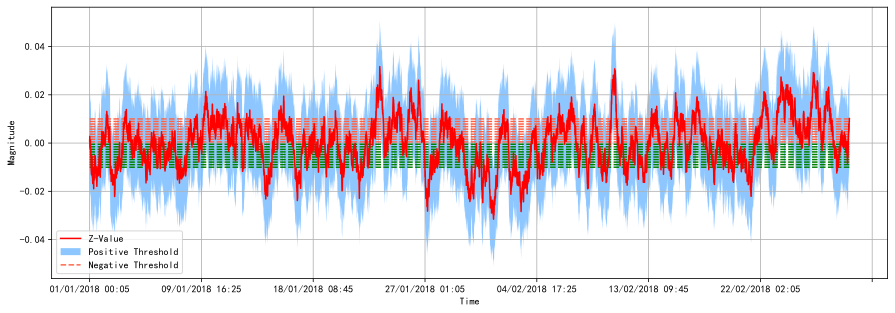

In [37]:
def Plot_Thresholds(stock1, stock2):
    zvalue = tradable_pairs_data[stock1+stock2,'Z-Value']
    plt.figure(figsize=(15,5))
    # plt.title('Error-correction term stock pair ' + stock1 + ' and ' + stock2)
    zvalue.plot(color='r')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    lower = np.array(zvalue) - 1.96*zvalue.std()
    upper = np.array(zvalue) + 1.96*zvalue.std()
    plt.fill_between(x=zvalue.index, y1=lower, y2=upper, facecolor="dodgerblue", alpha=0.5)
    xmin = 0
    xmax = len(zvalue)
    plt.hlines(pnl_threshold[pnl_threshold.index==(stock1, stock2)]['Thresholds'], xmin, xmax, 'Tomato', linestyles='--')  
    plt.hlines(-pnl_threshold[pnl_threshold.index==(stock1, stock2)]['Thresholds'], xmin, xmax, 'g', linestyles='--')
    plt.legend(['Z-Value', 'Positive Threshold', 'Negative Threshold'], loc='lower left')
    plt.grid(True)
    # plt.savefig("./imgs/res_thre_%s_%s"%(pair[0], pair[1]), dpi=400)
    plt.show()

for pair in stock_pairs[:1]:
    Plot_Thresholds(pair[0], pair[1])


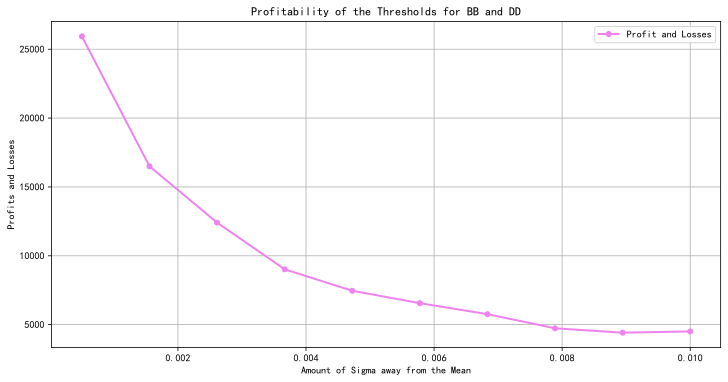

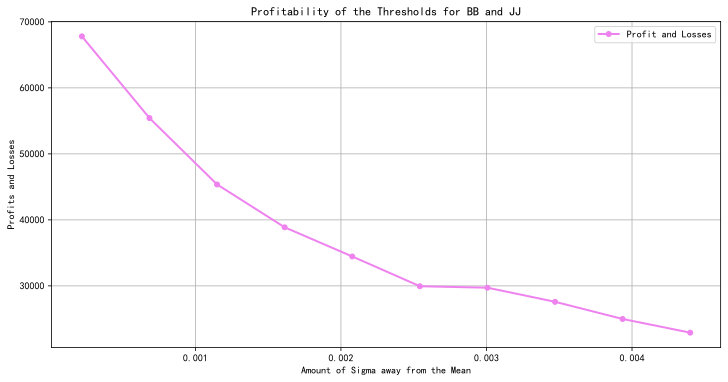

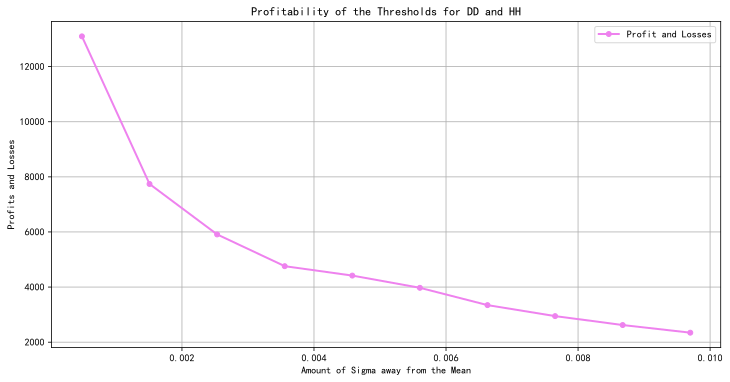

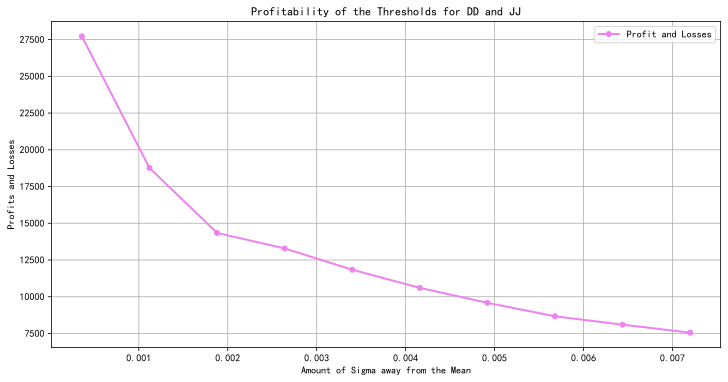

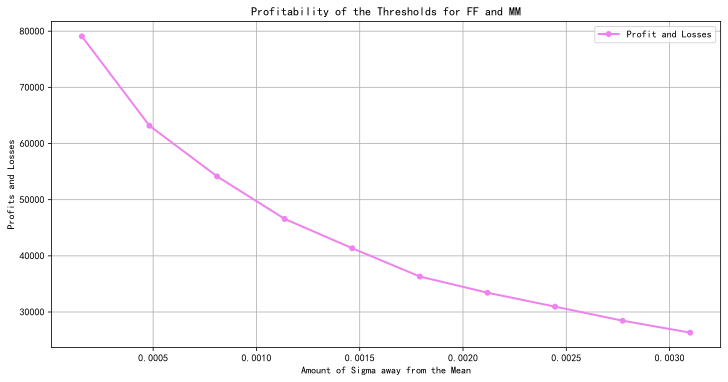

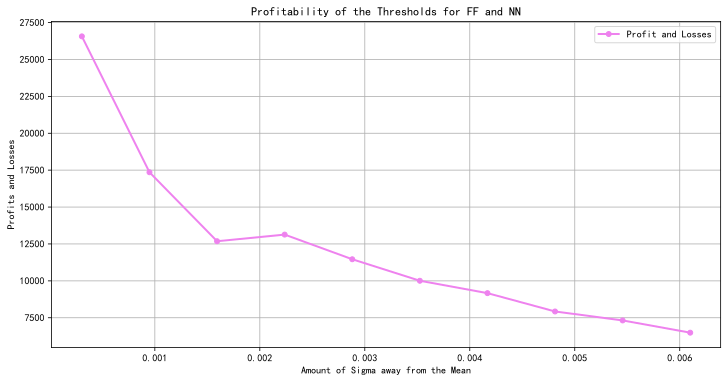

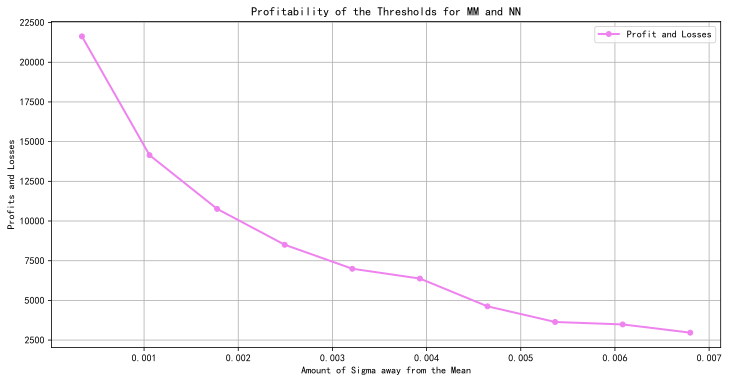

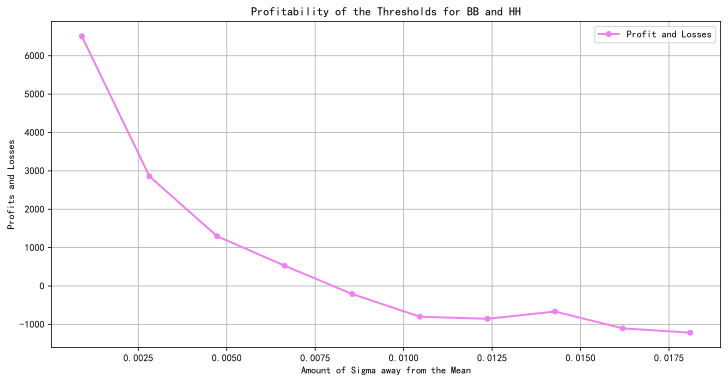

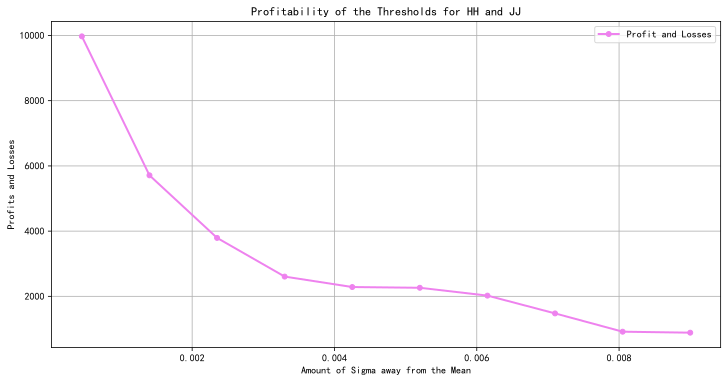

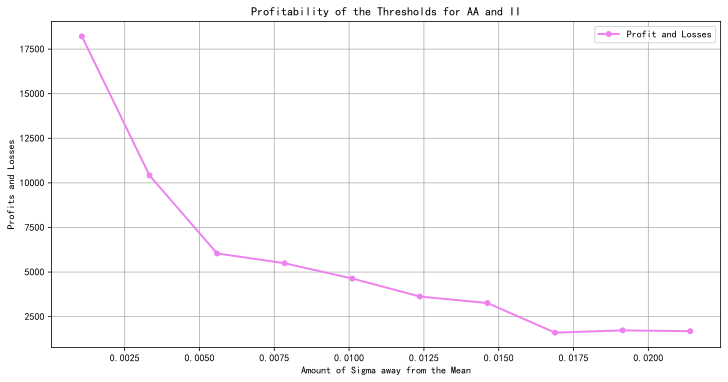

In [38]:
# Create a Plot that displays the Profitability of the Thresholds

# fig, ax = plt.subplots(1,1,figsize=(15,10))

def profitability_of_the_thresholds(stock1, stock2):
    pnl_threshold[(pnl_threshold.index == (stock1, stock2))].plot(x='Thresholds', y='PnLs', figsize=(12, 6), color='violet', marker='o', lw=2, markersize=5)
    
    plt.title('Profitability of the Thresholds for ' + stock1 + ' and ' + stock2)
    plt.xlabel('Amount of Sigma away from the Mean')
    plt.ylabel('Profits and Losses')
    plt.legend(['Profit and Losses'])
    plt.grid()
    plt.show()

for pair in stock_pairs:
    profitability_of_the_thresholds(pair[0],pair[1])

**Algorithm Strategy 1**

Making use of the previous analysis to determine which pairs should be traded. Based on that the algorithm, with slight modifications, is ran again to calculate the final profits.

In [39]:
highest_pnls

Thresholds      PnLs  rank
Pairs                               
(FF, MM)    0.000155  79082.70   1.0
(BB, JJ)    0.000220  67810.25   1.0
(DD, JJ)    0.000360  27720.25   1.0
(FF, NN)    0.000305  26567.50   1.0
(BB, DD)    0.000500  25935.80   1.0
(MM, NN)    0.000340  21631.40   1.0
(AA, II)    0.001070  18215.25   1.0
(DD, HH)    0.000485  13098.55   1.0
(HH, JJ)    0.000450   9973.30   1.0
(BB, HH)    0.000905   6505.80   1.0

In [40]:
# choice the pairs without overlapping assets
threshold_dictionary = {('BB', 'JJ'): 0.000220,
                        ('FF', 'MM'): 0.000155,
                        ('DD', 'HH'): 0.000485,
                        ('AA', 'II'): 0.001070}

threshold_dictionary

{('BB', 'JJ'): 0.00022,
 ('FF', 'MM'): 0.000155,
 ('DD', 'HH'): 0.000485,
 ('AA', 'II'): 0.00107}

In [41]:
# Selection of the final pairs for this trading strategy
stock_pairs_final = [('BB', 'JJ'),
                     ('FF', 'MM'),
                     ('DD', 'HH'),
                     ('AA', 'II')]

stock_pairs_final

[('BB', 'JJ'), ('FF', 'MM'), ('DD', 'HH'), ('AA', 'II')]

In [42]:
positions_strategy_1 = {}
limit = 10000

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    gamma = gamma_dictionary[stock1,stock2]
    
    threshold = threshold_dictionary[stock1,stock2]
        
    current_position = 0
    current_position_stock1 = 0 
    current_position_stock2 = 0 
    column_name_stock1 = stock1
    column_name_stock2 = stock2
    
    BidPrice_Stock1 = tradable_pairs_data[stock1,'BidPrice'][0]
    AskPrice_Stock1 = tradable_pairs_data[stock1,'AskPrice'][0]
    BidPrice_Stock2 = tradable_pairs_data[stock2,'BidPrice'][0]
    AskPrice_Stock2 = tradable_pairs_data[stock2,'AskPrice'][0]
    # print("bidprice1", BidPrice_Stock1)
    # print("askprice1", AskPrice_Stock1)
    # print("bidprice2", BidPrice_Stock2)
    # print("askprice2", AskPrice_Stock2)
    positions_strategy_1[column_name_stock1] = []
    positions_strategy_1[column_name_stock2] = []
    
    for time, data_at_time in tradable_pairs_data.iterrows():
        
        BidVolume_Stock1 = data_at_time[stock1, 'BidVolume']
        AskVolume_Stock1 = data_at_time[stock1, 'AskVolume']
        BidVolume_Stock2 = data_at_time[stock2, 'BidVolume']
        AskVolume_Stock2 = data_at_time[stock2, 'AskVolume']
        # print("bidvolume1", BidVolume_Stock1)
        # print("askvolume1", AskVolume_Stock1)
        # print("bidvolume2", BidVolume_Stock2)
        # print("askvolume2", AskVolume_Stock2)
        zvalue = data_at_time[stock1+stock2,'Z-Value']

        # close positions if any
        if ((zvalue <= 0) & (current_position == 1)) | ((current_position == -1) & (zvalue >= 0)):
            current_position_stock1 = 0
            current_position_stock2 = 0
            current_position = 0 

        # long stock 2, short stock 1
        if (zvalue >= threshold) & (current_position == 0):
            hedge_ratio = gamma * (BidPrice_Stock1 / AskPrice_Stock2)
            max_order_stock1 = np.floor(limit/BidPrice_Stock1)
            max_order_stock2 = np.floor(limit/AskPrice_Stock2)
            # print("hedge_ratio",hedge_ratio)
            # print("max_order_stock1",max_order_stock1)
            # print("max_order_stock2",max_order_stock2)
            # trade is the qty for stock 2, then trade * hedge_ratio is the qty for stock 1
            trade = np.floor(min(BidVolume_Stock1*hedge_ratio, AskVolume_Stock2, max_order_stock1*hedge_ratio, max_order_stock2))
            # print("trade",trade)
            # print("trade/hedge",trade/hedge_ratio)
            current_position_stock1 = -np.floor(trade/hedge_ratio)
            current_position_stock2 = trade
            current_position = 1

        elif (zvalue <= -threshold) & (current_position == 0):
            hedge_ratio = gamma * (AskPrice_Stock1 / BidPrice_Stock2)
            max_order_stock1 = np.floor(limit/AskPrice_Stock1)
            max_order_stock2 = np.floor(limit/BidPrice_Stock2)
            # print("hedge_ratio",hedge_ratio)
            # print("max_order_stock1",max_order_stock1)
            # print("max_order_stock2",max_order_stock2)
            # trade is the qty for stock 2, then trade * hedge_ratio is the qty for stock 1
            trade = np.floor(min(AskVolume_Stock1*hedge_ratio, BidVolume_Stock2, max_order_stock1*hedge_ratio, max_order_stock2))
            # print("trade",trade)
            # print("trade/hedge",trade/hedge_ratio)
            current_position_stock1 = np.floor(trade/hedge_ratio)
            current_position_stock2 = -trade
            current_position = -1

        positions_strategy_1[column_name_stock1].append(current_position_stock1)
        positions_strategy_1[column_name_stock2].append(current_position_stock2)

In [43]:
# Set Ceiling (to prevent positions with not enough volume available) as well as define the timestamp
positions_strategy_1 = np.ceil(pd.DataFrame(positions_strategy_1))
positions_strategy_1['Timestamp'] = tradable_pairs_data.index
positions_strategy_1 = positions_strategy_1.set_index('Timestamp')
positions_strategy_1

BB     JJ    FF     MM    DD    HH     AA     II
Timestamp                                                           
01/01/2018 00:05  61.0 -125.0 -88.0  100.0 -66.0  64.0  123.0 -118.0
01/01/2018 00:10  61.0 -125.0 -88.0  100.0 -66.0  64.0  123.0 -118.0
01/01/2018 00:15  61.0 -125.0 -88.0  100.0 -66.0  64.0  123.0 -118.0
01/01/2018 00:20  61.0 -125.0 -88.0  100.0 -66.0  64.0  123.0 -118.0
01/01/2018 00:25  61.0 -125.0 -88.0  100.0 -66.0  64.0  123.0 -118.0
...                ...    ...   ...    ...   ...   ...    ...    ...
28/02/2018 23:35  61.0 -125.0  88.0 -101.0 -66.0  64.0 -124.0  118.0
28/02/2018 23:40 -60.0  124.0  88.0 -101.0 -66.0  64.0 -124.0  118.0
28/02/2018 23:45 -60.0  124.0  88.0 -101.0 -66.0  64.0 -124.0  118.0
28/02/2018 23:50 -60.0  124.0  88.0 -101.0 -66.0  64.0 -124.0  118.0
28/02/2018 23:55 -60.0  124.0  88.0 -101.0 -66.0  64.0 -124.0  118.0

[16991 rows x 8 columns]

In [44]:
# The difference between the positions
positions_diff_strategy_1 = positions_strategy_1.diff()
positions_diff_strategy_1.iloc[0] = positions_strategy_1.iloc[0]
positions_diff_strategy_1

BB     JJ    FF     MM    DD    HH     AA     II
Timestamp                                                            
01/01/2018 00:05   61.0 -125.0 -88.0  100.0 -66.0  64.0  123.0 -118.0
01/01/2018 00:10    0.0    0.0   0.0    0.0   0.0   0.0    0.0    0.0
01/01/2018 00:15    0.0    0.0   0.0    0.0   0.0   0.0    0.0    0.0
01/01/2018 00:20    0.0    0.0   0.0    0.0   0.0   0.0    0.0    0.0
01/01/2018 00:25    0.0    0.0   0.0    0.0   0.0   0.0    0.0    0.0
...                 ...    ...   ...    ...   ...   ...    ...    ...
28/02/2018 23:35    0.0    0.0   0.0    0.0   0.0   0.0    0.0    0.0
28/02/2018 23:40 -121.0  249.0   0.0    0.0   0.0   0.0    0.0    0.0
28/02/2018 23:45    0.0    0.0   0.0    0.0   0.0   0.0    0.0    0.0
28/02/2018 23:50    0.0    0.0   0.0    0.0   0.0   0.0    0.0    0.0
28/02/2018 23:55    0.0    0.0   0.0    0.0   0.0   0.0    0.0    0.0

[16991 rows x 8 columns]

In [45]:
stock_pairs_final

[('BB', 'JJ'), ('FF', 'MM'), ('DD', 'HH'), ('AA', 'II')]

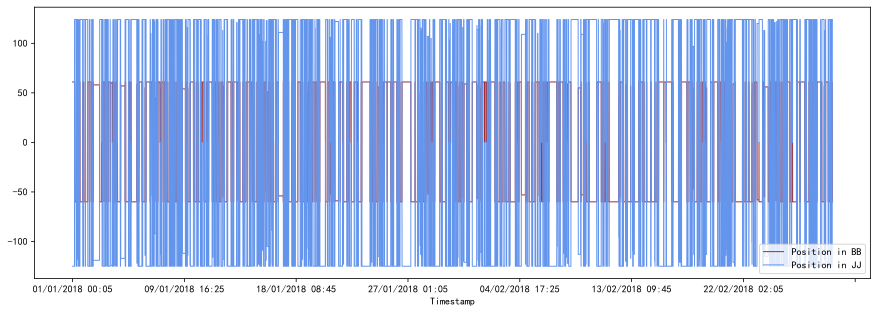

In [46]:
# Show Positions over Time
for pairs in stock_pairs_final[:1]:
    stock1 = pairs[0]
    stock2 = pairs[1]
    
    plt.figure(figsize=(15,5))
    
    positions_strategy_1[stock1].plot(color='brown', lw=1, markersize=3)
    positions_strategy_1[stock2].plot(color='CornflowerBlue', lw=1, markersize=3)
    
    # plt.title('Positions over Time for ' + stock1 + ' and ' + stock2)
    plt.legend(["Position in " + stock1,"Position in " + stock2], loc='lower right')
    # plt.grid()
    # plt.savefig("./imgs/pos_%s_%s"%(stock1, stock2), dpi=500)
    plt.show()

Re-run the PnL forloop to determine the profits. This could also be manually calculated with pnl_threshold values.

In [47]:
pnl_dataframe_strategy_1 = pd.DataFrame()

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    
    Stock1_AskPrice = tradable_pairs_data[stock1,'AskPrice'][:]
    Stock1_BidPrice = tradable_pairs_data[stock1,'BidPrice'][:]
    Stock2_AskPrice = tradable_pairs_data[stock2,'AskPrice'][:]
    Stock2_BidPrice = tradable_pairs_data[stock2,'BidPrice'][:]

    pnl_dataframe_strategy_1[stock1] = np.where(positions_diff_strategy_1[stock1] > 0, positions_diff_strategy_1[stock1] * -Stock1_BidPrice, positions_diff_strategy_1[stock1] * -Stock1_AskPrice)
    pnl_dataframe_strategy_1[stock2] = np.where(positions_diff_strategy_1[stock2] > 0, positions_diff_strategy_1[stock2] * -Stock2_BidPrice, positions_diff_strategy_1[stock2] * -Stock2_AskPrice)

print("The total profit is: €",round(pnl_dataframe_strategy_1.sum().sum()))

The total profit is: € 178207


In [48]:
pnl_dataframe_strategy_1['Timestamp'] = tradable_pairs_data.index[:]
pnl_dataframe_strategy_1 = pnl_dataframe_strategy_1.set_index('Timestamp')

pnl_dataframe_strategy_1['PnL'] = pnl_dataframe_strategy_1.sum(axis=1)
pnl_dataframe_strategy_1['Cum PnL'] = pnl_dataframe_strategy_1['PnL'].cumsum()

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]

    pnl_dataframe_strategy_1[stock1+stock2 + ' PnL'] = pnl_dataframe_strategy_1[stock1] + pnl_dataframe_strategy_1[stock2]
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'] = pnl_dataframe_strategy_1[stock1+stock2 + ' PnL'].cumsum()

pnl_dataframe_strategy_1.tail()

BB        JJ   FF   MM   DD   HH   AA   II      PnL    Cum PnL  BBJJ PnL  BBJJ Cum PnL  FFMM PnL  FFMM Cum PnL  DDHH PnL  DDHH Cum PnL  AAII PnL  \
Timestamp                                                                                                                                                                 
28/02/2018 23:35     -0.0     -0.00 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0     0.00  185776.20     -0.00      75379.70      -0.0       79082.7      -0.0      13098.55      -0.0   
28/02/2018 23:40  11616.0 -19185.45 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -7569.45  178206.75  -7569.45      67810.25      -0.0       79082.7      -0.0      13098.55      -0.0   
28/02/2018 23:45     -0.0     -0.00 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0     0.00  178206.75     -0.00      67810.25      -0.0       79082.7      -0.0      13098.55      -0.0   
28/02/2018 23:50     -0.0     -0.00 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0     0.00  178206.75     -0.00      67810.25      -0.0       79082.7      -0.0      13098.55      -0.0   
28/02/2018 23:55     -0.0     -0.00 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0     0.00  178206.75     -0.00      67810.25      -0.0       79082.7      -0.0      13098.55      -0.0   

                  AAII Cum PnL  
Timestamp                       
28/02/2018 23:35      18215.25  
28/02/2018 23:40      18215.25  
28/02/2018 23:45      18215.25  
28/02/2018 23:50      18215.25  
28/02/2018 23:55      18215.25

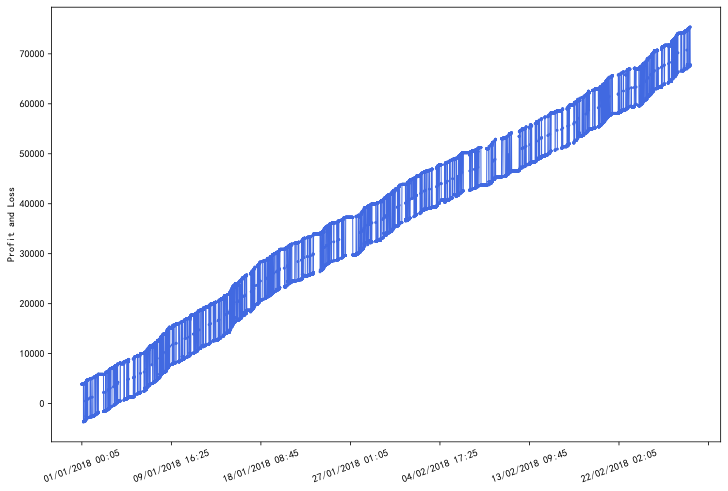

In [54]:
# All Pairs's PnL

for pair in stock_pairs_final[:1]:
    stock1 = pair[0]
    stock2 = pair[1]
    
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'].plot(figsize=(12,8), color='RoyalBlue', marker='o',lw = 1,markersize = 2)
    # plt.title('Cumulative PnL of ' + stock1 + ' and ' + stock2)
    plt.ylabel('Profit and Loss')
    plt.xlabel("")
    # plt.grid()
    plt.xticks(rotation=20)
    # plt.savefig("./imgs/pnl_%s_%s.png"%(stock1, stock2), dpi=500)
    plt.show()


In [50]:
pnl_dataframe_strategy_1['Cum PnL']

Timestamp
01/01/2018 00:05      2150.90
01/01/2018 00:10      2150.90
01/01/2018 00:15      2150.90
01/01/2018 00:20      2150.90
01/01/2018 00:25      2150.90
                      ...    
28/02/2018 23:35    185776.20
28/02/2018 23:40    178206.75
28/02/2018 23:45    178206.75
28/02/2018 23:50    178206.75
28/02/2018 23:55    178206.75
Name: Cum PnL, Length: 16991, dtype: float64

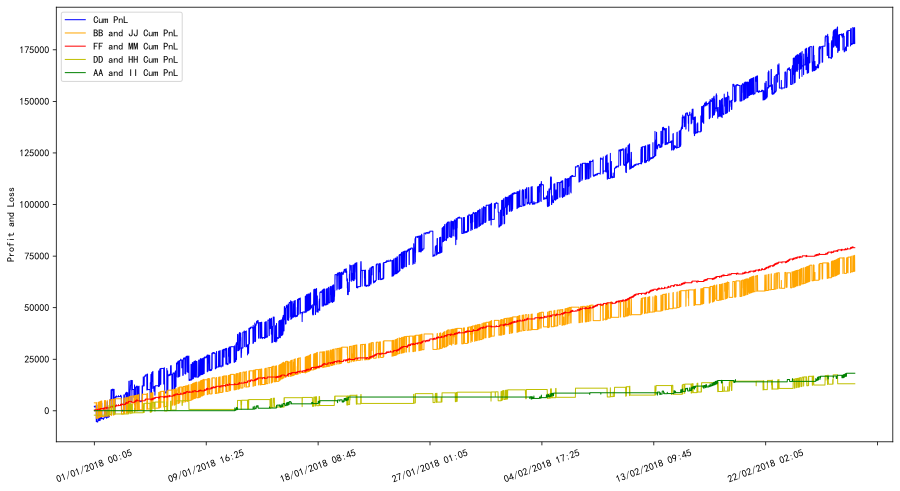

In [51]:
# All Pairs's PnLs (including total) in one graph

color_ = ['orange','r','y','g','b']
pnl_dataframe_strategy_1['Cum PnL'].plot(color='b',lw = 1)

for pair in stock_pairs_final:
    stock1 = pair[0]
    stock2 = pair[1]
    pnl_dataframe_strategy_1[stock1+stock2 + ' Cum PnL'].plot(figsize=(15,8), color=color_[stock_pairs_final.index(pair)%len(color_)],lw = 1)
    plt.legend(['Cum PnL', 'BB and JJ Cum PnL', 'FF and MM Cum PnL', 'DD and HH Cum PnL','AA and II Cum PnL'])
    # plt.title('Cumulative PnLs of the Trading Strategy')
    plt.ylabel('Profit and Loss')
    plt.xlabel("")
    # plt.grid()
    # plt.savefig("./imgs/all_pnl.png", dpi=500)
    plt.xticks(rotation=20)

In [52]:
# Send to CSV
pnl_dataframe_strategy_1.to_csv('./res/pnl_final_portfolio_results.csv')